<h1 style="text-align: center;">Python pour la Gestion d'actifs</h1>

Dans ce notebook, nous verrons l'intérêt de Python dans la gestion d'actifs. Que ce soit pour la création d'une stratégie d'investissement ou sa mise en pratique au quotidien.

Nous aborderons les problématiques suivantes :
- Création d'un programme d'optimisation de portefeuille
- Définition d'une stratégie d'investissement
- Backtest de cette dernière

In [5]:
from sklearn.covariance import ShrunkCovariance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bt
import ffn
%matplotlib inline

#### Extraction des données ####

In [6]:
my_path = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\"
constit = pd.read_excel(my_path + "nasdaq100_constituents_prices.xlsx",sheet_name="Feuil2",header=0, index_col=0, parse_dates=True)
indice = pd.read_excel(my_path + "nasdaq100_index_prices.xlsx", header=0, index_col=0, parse_dates=True)

#### Préparation des données ####

Je joins les deux jeux de données en appliquant la méthode ***merge_asof***. Cette méthode permet d'effectuer des jointures sur des dates, et de compléter les données manquantes, avec celles des jours précédents (dans un intervalle de temps donné, ici 5 jours).

In [7]:
tol = pd.Timedelta('5 day')
merged = pd.merge_asof(constit.sort_values('date'), indice, on='date', tolerance=pd.Timedelta('5 day'))
merged.index = merged["date"] # Je repasse les dates en index, c'est plus simple pour les traitements ultérieurs
merged = merged.drop('date', axis=1) # et je supprime la colonne, qui n'est plus utile
merged = merged.fillna(0) # Pour les backtests, je remplace les valeurs manquantes par 0.

Dans un premier temps, nous allons voir comment construire un portefeuille à l'aide d'algorithmes d'optimisation. Il n'est pas question ici de donner un état des lieux complet des optimisations possibles, mais plutôt de montrer comment elles sont mises en place dans des modules spécialisés. Nous comparerons nos résultats avec ceux de modules externes.

Nous allons implémenter deux programmes d'optimisation que vous devez déjà connaître :

**Minimum-Variance**
<p><br></p>
<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; text-align: center; width:50%; margin:auto;">
$\min \bar{\sigma} = w^T∑w$<br>
s.c. <br>
$ w^T1 = 1$<br>
$0 \le w \le 1$<br>
</p>



**Moyenne-Variance**
<p><br></p>
<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; text-align: center; width:50%; margin:auto;">
$\min \bar{\sigma} = w^T∑w$<br>
s.c. <br>
$ w^T\mu = \bar{r}$<br>
$ w^T1 = 1$<br>
$0 \le w \le 1$<br>

In [8]:
def portfolio_variance(w, S):
    """ objective function for minimum variance optimization problem """
    return np.dot(np.dot(w, S), w)

def portfolio_return(w, mu):
    """ estimate portfolio return with given weights and expected returns """
    return np.dot(w, mu)  

def portfolio_optimization(ret, typeOpt, robust=False, **kwargs):
    """ function to solve minimization problem """

    TOLERANCE = 1e-15
    target = kwargs.get('TARGET_RETURN')
    
    # REMARQUE :
    # Les rendements que nous avons donnés en paramètre de cette fonction sont journaliers, c'est pourquoi
    # plus bas dans le code je divise mon objectif de rendement par 252 (il y a en moyenne 252 jours ouvrés
    # dans une année).
    # Il est IMPORTANT d'effectuer les calculs sur des données qui ont la MEME FREQUENCE (risk & rendement)

    if robust == True:
        real_cov = np.cov(ret, rowvar=False)
        cov = ShrunkCovariance().fit(real_cov).covariance_ # méthode de shrinkage / compression de la matrice de covariance
    else:
        cov = np.cov(ret, rowvar=False)

    mean_ret = ret.mean()

    w = np.ones(cov.shape[0])/cov.shape[0]
    e = np.ones(cov.shape[0])
    
    bds = [(0.0, 1.0) for i in range(0, len(e))] # Ici il est possible de définir les bornes de l'optimisation
    
    if typeOpt == "minimum_variance":
        const = ({'type' : 'eq' , 'fun' : lambda w: np.dot(w, e) - 1.}) # contrainte de la somme des poids égale à 1
        solution = minimize(fun=portfolio_variance, x0=w, args=(cov), bounds=bds, method='SLSQP', constraints=const, tol=TOLERANCE)
    elif typeOpt == "mean_variance":
        const = (
            {'type' : 'eq' , 'fun' : lambda w: np.dot(w, mean_ret) - float(target)/252.}, # contrainte sur le rendement
            {'type' : 'eq' , 'fun' : lambda w: np.dot(w, e) - 1.} # contrainte de la somme des poids égale à 1
        )
        solution = minimize(fun=portfolio_variance, x0=w, args=(cov), bounds=bds, method='SLSQP', constraints=const, tol=TOLERANCE)
    else:
        return w
    
    w_star = solution.x.round(6)
    return dict(zip(ret.columns, w_star))

In [9]:
TARGET_RETURN = 0.12 # Notre rendement cible
daily_returns = constit[["MSFT.US","AMZN.US","AAPL.US","QCOM.US","NVDA.US"]].tail(500).pct_change().dropna()

min_var = portfolio_optimization(daily_returns, "minimum_variance")
target_ret = portfolio_optimization(daily_returns, "mean_variance", TARGET_RETURN=0.12)
print("minimum variance : ", min_var)
print("moyenne variance : ", target_ret)

minimum variance :  {'MSFT.US': 0.590657, 'AMZN.US': 0.0, 'AAPL.US': 0.409343, 'QCOM.US': 0.0, 'NVDA.US': 0.0}
moyenne variance :  {'MSFT.US': 0.38537, 'AMZN.US': 0.0, 'AAPL.US': 0.433047, 'QCOM.US': 0.0, 'NVDA.US': 0.181582}


In [10]:
print("Statistiques sur le portefeuille minimum variance : ")
port_var = portfolio_variance(list(min_var.values()), daily_returns.cov())
port_ret = portfolio_return(list(min_var.values()), daily_returns.mean())
print(f"Volatilité annualisée : {np.sqrt(port_var)*np.sqrt(252):.5%}")
print(f"Rendement espéré : {port_ret * 252:.2%}")

Statistiques sur le portefeuille minimum variance : 
Volatilité annualisée : 28.12584%
Rendement espéré : 6.96%


In [11]:
print("Statistiques sur le portefeuille moyenne variance : ")
port_var2 = portfolio_variance(list(target_ret.values()), daily_returns.cov())
port_ret2 = portfolio_return(list(target_ret.values()), daily_returns.mean())
print(f"Volatilité annualisée : {np.sqrt(port_var2)*np.sqrt(252):.2%}")
print(f"Rendement espéré : {port_ret2 * 252:.2%}")

Statistiques sur le portefeuille moyenne variance : 
Volatilité annualisée : 31.43%
Rendement espéré : 12.00%


*Comment vérifier que nous avons bien le portefeuille de variance minimale ?*

Nous allons générer un grand nombre de portefeuilles aléatoires à partir desquels nous pourrons vérifier que notre programme d'optimisation est efficace. Si des portefeuilles, issus de ces simulations, permettent d'obtenir un portefeuille dont la volatilité annualisée est inférieure à celle du programme d'optimisation, alors ce dernier n'aura pas été en capacité de trouver un optimum global.

In [15]:
def random_portfolios(nb_sim, returns):
    results = dict()
    
    for i in range(nb_sim):
        w = ffn.random_weights(returns.shape[1])
        
        risk = portfolio_variance(w, returns.cov())
        results.update({
            i:{
                'perf':np.dot(w, returns.mean()) * 252.,
                'risk':np.sqrt(risk)*np.sqrt(252),
                'weights':np.round(w,4)
            }
        })
    return pd.DataFrame().from_dict(results, orient='index')

Il existe une infinité de combinaisons possibles et pour être sûr de s'approcher du minimum global, il faut générer un très grand nombre de portefeuilles. Dans notre exemple, nous allons en générer ***un million***.

>Le code n'étant pas optimisé ce processus peut prendre un peu de temps. Sur mon ordinateur, il prend environ 5 minutes...

In [16]:
#all_ptf = random_portfolios(1000000, daily_returns)

Maintenant que nous avons généré un million de portefeuille, avec les statistiques qui nous intéressent, voyons si nous obtenons une solution proche de celle de notre programme d'optimisation.

In [17]:
#all_ptf[all_ptf.risk == np.min(all_ptf.risk)]

On peut effectivement remarquer que le portefeuille issu des simulations numériques qui a la plus petite variance est très proche du portefeuille issu du programme d'optimisation. On remarque cependant qu'il n'est pas aussi précis que ce dernier dont la variance est encore plus faible.

Caractéristiques :
- Volatilité annualisée espérée : 28.12***61***% vs 28.12***58***% pour le programme d'optimisation
- Rendement annualisé espéré : 6.96%

Il faudrait générer encore plus de portefeuilles pour être sûr d'approcher un peu plus l'optimum global.

In [18]:
#all_ptf[(all_ptf.perf >= TARGET_RETURN)].sort_values("risk", ascending=True)

NameError: name 'all_ptf' is not defined

Dans les cellules qui vont suivre, nous allons reproduire la procédure en utilisant un module externe : PyPortfolioOpt.

Vous trouverez la documentation de ce module ici : https://pyportfolioopt.readthedocs.io/en/latest/index.html

In [19]:
from pypfopt import EfficientFrontier, risk_models

sigma = risk_models.risk_matrix(daily_returns, method='sample_cov', returns_data=True) # calcul de la matrice de variance-covariance

min_var2 = EfficientFrontier(daily_returns.mean(), sigma) # définition de la frontière efficiente
min_var2.min_volatility() # de laquelle on extrait le portefeuille de variance minimale

OrderedDict([('MSFT.US', 0.5906567107458042),
             ('AMZN.US', 0.0),
             ('AAPL.US', 0.4093432892541958),
             ('QCOM.US', 0.0),
             ('NVDA.US', 0.0)])

In [20]:
target_ret2 = EfficientFrontier(daily_returns.mean(), sigma)
target_ret2.efficient_return(TARGET_RETURN/252)

OrderedDict([('MSFT.US', 0.3853701199463215),
             ('AMZN.US', 0.0),
             ('AAPL.US', 0.4330474863285054),
             ('QCOM.US', 0.0),
             ('NVDA.US', 0.181582393725173)])

Ci-dessous, un tableau récapitulatif des résultats :

| Optimisation     | Module/Méthode | Vol. Ann. (es) | Perf Ann. | Poids                                                          |
|:------------------|:----------------|:----------------:|:-----------:|:----------------------------------------------------------------|
| Minimum Variance | Custom         | 28.1258% | 6.96%|MSFT : 59.06%, AMZN : 0.00%, AAPL : 40.93%, QCOM : 0.00%, NVDA : 0.00%|
| Minimum Variance | Simulation     | 28.1261%  | 6.96%|MSFT : 58.77%, AMZN : 0.01%, AAPL : 41.21%, QCOM : 0.01%, NVDA : 0.00%|
| Minimum Variance | PyPortfolioOpt | 28.1258% | 6.96%|MSFT : 59.06%, AMZN : 0.00%, AAPL : 40.93%, QCOM : 0.00%, NVDA : 0.00%|
| Moyenne Variance | Custom         | 31.44% |12.01%|MSFT : 38.53%, AMZN : 0.00%, AAPL : 43.30%, QCOM : 0.00%, NVDA : 18.15% |
| Moyenne Variance | Simulation     | 31.48% |12.03%|MSFT : 39.75%, AMZN : 0.01%, AAPL : 41.28%, QCOM : 0.05%, NVDA : 18.39%|
| Moyenne Variance | PyPortfolioOpt | 31.44% |12.01%|MSFT : 38.53%, AMZN : 0.00%, AAPL : 43.30%, QCOM : 0.00%, NVDA : 18.15% |


#### Construction d'une stratégie de réplication d'indice ####

Il existe plusieurs méthodes pour répliquer un indice de marché :
- La réplication physique : elle consiste a répliquer un indice de marché en achetant tous les titres constituant cet indice, et en appliquant les mêmes pondérations que ce dernier. Bien que cette méthode soit facile à mettre en place, elle est particulièrement inefficace pour les grands indices car :
    - Les coûts de transactions peuvent obérer la performance de la stratégie et créer des variations inattendues avec l'indice.
    - Le suivi d'un univers large d'actifs est forcément plus compliqué à effectuer (gestion des sorties d'indices, des titres illiquides, etc).
- La réplication synthétique : cette dernière consiste à acheter des produits dérivés indexés sur l'indice que l'on souhaite répliquer : bien que cette méthode soit également facile à mettre en place, elle peut manquer d'efficacité lors de certaines phases de marché car la valorisation des produits dérivés n'est pas entièrement liée à l'indice sous-jacent, mais aussi parce que l'utilisation de produits dérivés peut rendre inéligibles ces fonds à certains supports d'investissements (e.g l'assurance-vie, le PEA, etc).
- La réplication par échantillonnage : cette méthode consiste à sélectionner des composantes de l'indice qui sont suffisament représentatives de l'indice, et d'appliquer un programme d'optimisation visant à réduire la ***tracking error*** entre notre panier d'actifs et l'indice sous-jacent.

Dans les travaux qui vont suivre, nous allons tenter de répliquer la performance du Nasdaq 100 grâce à la méthode d'échantillonnage :

<p><br></p>
<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; text-align: center; width:50%,; margin:auto; color:black;">
$ \min TE = (w-w_{b})^{T} (w-w_{b})$<br><br>
s.c.<br> 
$w^T1 = 1$<br>
$0 \le w \le 1$<br><br>
avec :<br>
$w_{b}$ : les rendements du benchmark;<br>
$w$ : les rendements du portefeuille<br>
</p>

In [21]:
def time_series_frequence_inference(dates):
    """Find the most frequent Timedelta days"""

    delta_days = dates.to_series().diff().value_counts().idxmax().days

    if delta_days > 20:
        return "Monthly"
    elif delta_days > 4:
        return "Weekly"
    elif delta_days < 4:
        return "Daily"
    else:
        return "Annualy"

def annualization_factor(freq):
    """Define the annualization factor according to time series frequence"""
    if freq == "Monthly":
        return 12
    elif freq == "Weekly":
        return 52
    elif freq == "Daily":
        return 252
    else:
        return 1

Il existe plusieurs méthodes pour estimer la tracking error. Dans ce notebook, je développe les deux suivantes :

*Empirical tracking error (ETE):* 

$ETE(w)=\frac{1}{T}\|r^b-Xw\|^2_2$

*Downside risk (DR):*

$DR(w)=\frac{1}{T}\|(r^b-Xw)^+\|^2_2$

In [22]:
def tracking_error(sec_prices, index_prices, method="ete"):
    freq = time_series_frequence_inference(sec_prices.index)

    sec_returns = sec_prices.pct_change().dropna()
    index_returns = index_prices.pct_change().dropna()
    
    if method == "ete": # Empirical Tracking Error
        errors = (sec_returns - index_returns)**2
        te = np.sum(errors/sec_returns.shape[0])**(1/2)
    else: # Downside Risk
        errors = sec_returns - index_returns
        squared = errors[errors > 0.]**2
        te = np.sum(squared/sec_returns.shape[0])**(1/2)
        
    return te * np.sqrt(annualization_factor(freq))

In [23]:
sq = tracking_error(merged['MSFT.US'].tail(250), merged['NDX.INDX'].tail(250), "ete")
dsr = tracking_error(merged['MSFT.US'].tail(250), merged['NDX.INDX'].tail(250), "dsr")

print(f"squared errors method : {sq:.2%}")
print(f"downside risk method : {dsr:.2%}")

squared errors method : 15.20%
downside risk method : 10.41%


In [24]:
def portfolio_tracking_error(w, sec_prices, index_prices, method="ete"):
    freq = time_series_frequence_inference(sec_prices.index)

    sec_returns = sec_prices.pct_change().dropna()
    index_returns = index_prices.pct_change().dropna()
    
    if method == "ete":
        errors = (w @ sec_returns.T - index_returns)**2
        te = np.sum(errors/sec_returns.shape[0])**(1/2)
    else:
        # Downside Risk Method
        errors = w @ sec_returns.T - index_returns
        squared = errors[errors > 0.]**2
        te = np.sum(squared/sec_returns.shape[0])**(1/2)

    return te * np.sqrt(annualization_factor(freq))

In [25]:
def min_tracking_error(sec_prices, index_prices, method='ete', boundaries=(0.0, 1.0)):
    TOLERANCE = 1e-12
    w = np.ones(sec_prices.shape[1])/sec_prices.shape[1]
    e = np.ones(sec_prices.shape[1])
    const = ({'type' : 'eq' , 'fun' : lambda w: np.dot(w, e) - 1.})
        
    bds = [boundaries for i in range(0, len(e))]

    solution = minimize(fun=portfolio_tracking_error, x0=w, args=(sec_prices, index_prices, method), bounds=bds, method='SLSQP', constraints=const, tol=TOLERANCE) 
    return solution.x.round(4)

Les éléments de code qui suivent implémente des classes et des méthodes issues du mobule bt pour les backtests.

Lien vers la documentation du projet : https://pmorissette.github.io/bt/


In [26]:
class StatTrackingError(bt.Algo):
    def __init__(self, bench_ticker, lookback=pd.DateOffset(months=12), lag=pd.DateOffset(days=0), method="ete"):
        self.bench_ticker = bench_ticker
        self.lookback = lookback
        self.lag = lag
        self.method = method
        
    def __call__(self, target):
        t0 = target.now - self.lookback
        prices = target.universe[(target.universe.index >= t0) & (target.universe.index <= target.now)]
        track_errors = prices.apply(lambda x: tracking_error(x, prices[self.bench_ticker], method=self.method))
        track_errors.replace(np.inf, 100, inplace=True) # je remplace les inf par 100.
        target.temp['stat'] = track_errors[track_errors > 0.]
        return True

In [27]:
class PortfolioWeights(bt.Algo):
    def __init__(self, bench_ticker, lookback=pd.DateOffset(months=12), lag=pd.DateOffset(days=0), method="ete"):
        self.bench_ticker = bench_ticker
        self.lookback = lookback
        self.lag = lag
        self.method = method
        
    def __call__(self, target):
        t0 = target.now - self.lookback
        prices = target.universe[(target.universe.index >= t0) & (target.universe.index <= target.now)]
        list_weights = min_tracking_error(prices[target.temp['selected']], prices[self.bench_ticker], self.method)
        dict_weights = {target.temp['selected'][i]:list_weights[i] for i in range(len(target.temp['selected']))}
        target.temp['weights'] = dict_weights
        return True

In [28]:
class SelectSecurities(bt.Algo):
    def __init__(self, threeshold):
        self.threeshold = threeshold
        
    def __call__(self, target):
        selection = target.temp['stat'][(target.temp['stat'] > 0.) & (target.temp['stat'] < self.threeshold)]
        target.temp['selected'] = selection.index
        return True

Pour minTE, la stratégie consiste à :
1. Estimer la tracking-error de tous les titres de l'univers (qui ont au moins 252 jours d'historique);
2. Sélectionner les X titres qui ont la plus petite tracking error;
3. Opérer un programme d'optimisation dont l'objectif est de minimiser la tracking error du portefeuille.

>Nous n'avons pas mis en place de frais de courtage ou de slippage dans les stratégies. Cela biaise quelque peu les résultats du backtest puisque ces derniers auraient forcément eu un impact sur la stratégie.

In [29]:
strat1 = bt.Strategy("minTE_univ60_ete",
    algos = [
        bt.algos.RunAfterDays(252),
        bt.algos.RunMonthly(),
        bt.algos.SelectHasData(min_count=252, include_negative=False),
        StatTrackingError(bench_ticker="NDX.INDX"),
        bt.algos.SelectN(60, sort_descending=True),
        PortfolioWeights(bench_ticker="NDX.INDX"),
        bt.algos.CloseDead(),
        bt.algos.Rebalance()
    ]
)

In [30]:
strat2 = bt.Strategy("minTE_seuil_ete_fees",
    algos = [
        bt.algos.RunAfterDays(252),
        bt.algos.RunMonthly(),
        bt.algos.SelectHasData(min_count=252, include_negative=False),
        StatTrackingError(bench_ticker="NDX.INDX"),
        #bt.algos.Debug(),
        SelectSecurities(0.25),
        PortfolioWeights(bench_ticker="NDX.INDX"),
        #bt.algos.PrintDate(),
        bt.algos.CloseDead(),
        bt.algos.Rebalance()
    ]
)

Pour minTE_seuil, la stratégie consiste à :
1. Estimer la tracking-error de tous les titres de l'univers (qui ont au moins 252 jours d'historique)
2. Sélectionner tous les titres dont la tracking error est inférieure à X%
3. Opérer un programme d'optimisation dont l'objectif est de minimiser la tracking error du portefeuille.

In [31]:
strat3 = bt.Strategy("minTE_seuil_ete",
    algos = [
        bt.algos.RunAfterDays(252),
        bt.algos.RunMonthly(),
        bt.algos.SelectHasData(min_count=252, include_negative=False),
        StatTrackingError(bench_ticker="NDX.INDX"),
        #bt.algos.Debug(),
        SelectSecurities(0.25),
        PortfolioWeights(bench_ticker="NDX.INDX"),
        #bt.algos.PrintDate(),
        bt.algos.CloseDead(),
        bt.algos.Rebalance()
    ]
)

In [32]:
strat4 = bt.Strategy("minTE_seuil_dsr",
    algos = [
        bt.algos.RunAfterDays(252),
        bt.algos.RunMonthly(),
        bt.algos.SelectHasData(min_count=252, include_negative=False),
        StatTrackingError(bench_ticker="NDX.INDX", method="dsr"),
        SelectSecurities(0.2),
        PortfolioWeights(bench_ticker="NDX.INDX", method='dsr'),
        bt.algos.CloseDead(),
        bt.algos.Rebalance()
    ]
)

In [33]:
#bkt1 = bt.Backtest(
# strat1, 
# merged[merged.index > "2019-01-01"], 
# progress_bar=True
# )

bkt2 = bt.Backtest(
    strat2, 
    merged[merged.index > "2019-01-01"], 
    commissions=lambda q, p: abs(q) * 0.01,
    progress_bar=True
    )

bkt3 = bt.Backtest(
    strat3, 
    merged[merged.index > "2019-01-01"],
    progress_bar=True
    )

bkt4 = bt.Backtest(
    strat4, 
    merged[merged.index > "2019-01-01"], 
    progress_bar=True
    )

In [34]:
report = bt.run(bkt2, bkt3, bkt4)

minTE_seuil_ete_fees
0% [############################# ] 100% | ETA: 00:00:05minTE_seuil_ete
0% [############################# ] 100% | ETA: 00:00:05minTE_seuil_dsr
0% [############################# ] 100% | ETA: 00:00:12

In [35]:
report.stats

,minTE_seuil_ete_fees,minTE_seuil_ete,minTE_seuil_dsr
start,2019-01-01 00:00:00,2019-01-01 00:00:00,2019-01-01 00:00:00
end,2023-01-31 00:00:00,2023-01-31 00:00:00,2023-01-31 00:00:00
rf,0.0,0.0,0.0
total_return,0.390592,0.392299,0.3983
cagr,0.084126,0.084451,0.085595
max_drawdown,-0.361338,-0.36111,-0.354084
calmar,0.232817,0.233866,0.241735
mtd,0.078104,0.078127,0.098114
three_month,0.0985,0.098523,0.105059
six_month,-0.041577,-0.041441,-0.020213


In [36]:
def rebased_from_date(prices, rebased_dt):
    idx = np.where(prices.index ==  rebased_dt)[0][0]
    return prices.iloc[idx:] / prices.iloc[idx] * 100.

In [37]:
strat_merged = pd.concat([report.prices, merged['NDX.INDX']], axis=1, join="inner")

In [38]:
rebased = rebased_from_date(strat_merged, "2020-01-02")

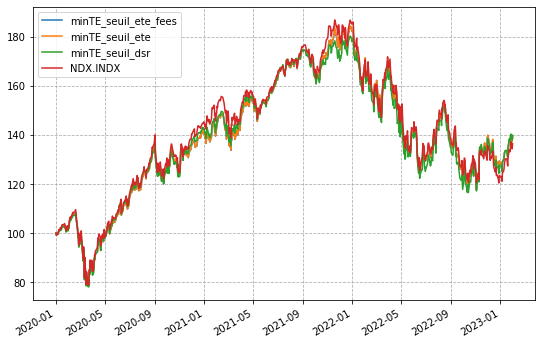

In [39]:
rebased.plot(figsize=(9, 6))
plt.grid(linestyle="--")

In [40]:
ffn.GroupStats(rebased).display()

Stat                 minTE_seuil_ete_fees    minTE_seuil_ete    minTE_seuil_dsr    NDX.INDX
-------------------  ----------------------  -----------------  -----------------  ----------
Start                2020-01-02              2020-01-02         2020-01-02         2020-01-02
End                  2023-01-31              2023-01-31         2023-01-31         2023-01-31
Risk-free rate       0.00%                   0.00%              0.00%              0.00%

Total Return         39.08%                  39.23%             39.83%             36.40%
Daily Sharpe         0.51                    0.51               0.51               0.49
Daily Sortino        0.82                    0.82               0.84               0.77
CAGR                 11.30%                  11.34%             11.50%             10.60%
Max Drawdown         -36.13%                 -36.11%            -35.41%            -35.56%
Calmar Ratio         0.31                    0.31               0.32               0.30



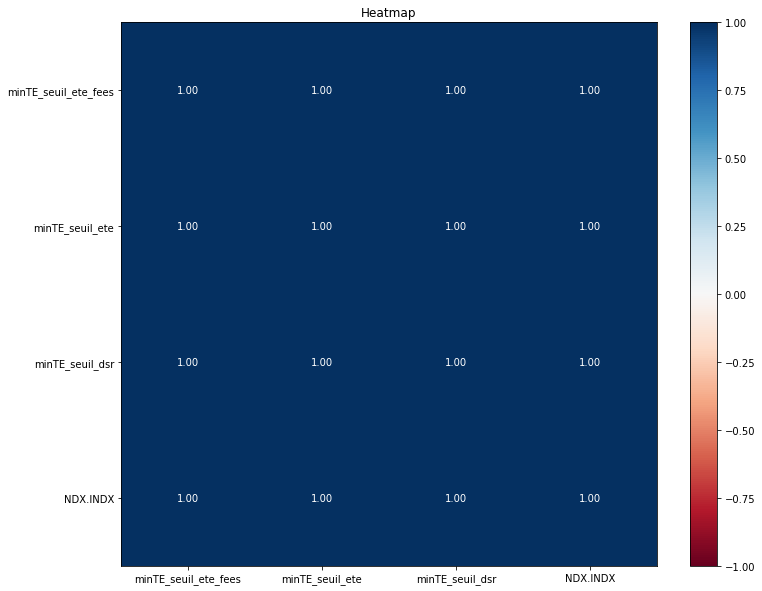

In [41]:
ffn.plot_corr_heatmap(rebased, figsize=(12, 10));

In [42]:
res = []
for current_bkt in report.backtests.values():
    historical_positions = current_bkt.strategy.positions
    res.append(historical_positions.apply(lambda x: x[x > 0.].count(), axis=1))

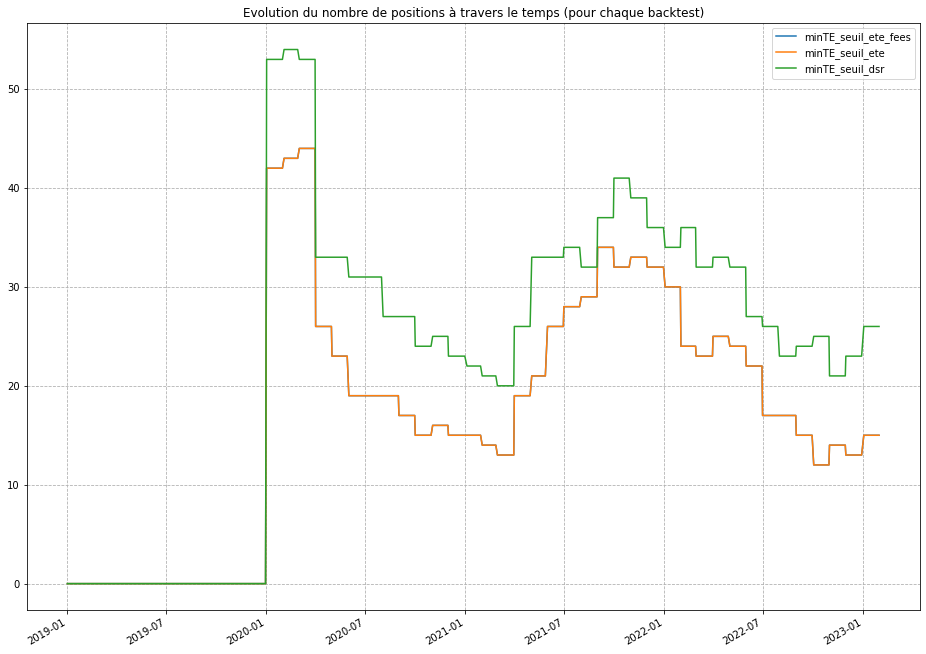

In [43]:
pd.DataFrame(res).T.plot(figsize=(16, 12))
plt.legend(report.backtests.keys())
plt.title("Evolution du nombre de positions à travers le temps (pour chaque backtest)")
plt.grid(linestyle="--")

In [44]:
def rolling_te(strat, indice, span=60):
    result = []
    for i in range(span, strat.shape[0]):
        te = tracking_error(strat.iloc[(i-span):i], indice.iloc[(i-span):i])
        result.append(te)
    return result
    

In [45]:
histo_dsr = rolling_te(rebased["minTE_seuil_dsr"], rebased["NDX.INDX"], span=60)
histo_ete = rolling_te(rebased["minTE_seuil_ete"], rebased["NDX.INDX"], span=60)
histo_ete_fees = rolling_te(rebased["minTE_seuil_ete_fees"], rebased["NDX.INDX"], span=60)

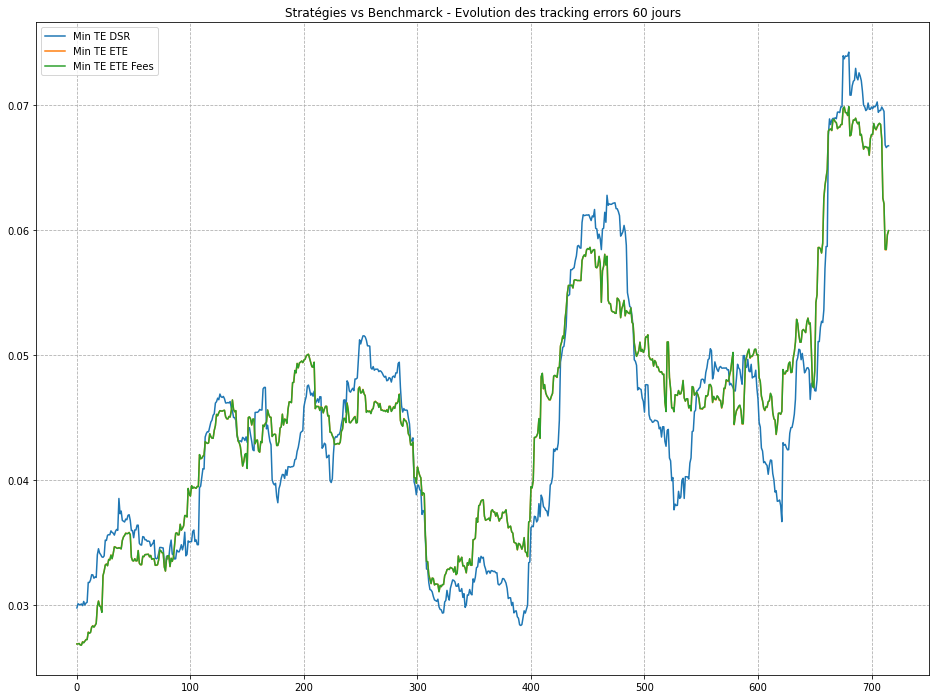

In [46]:
plt.figure(figsize=(16,12))
plt.plot(histo_dsr, label="Min TE DSR")
plt.plot(histo_ete, label="Min TE ETE")
plt.plot(histo_ete_fees, label="Min TE ETE Fees")
plt.title("Stratégies vs Benchmarck - Evolution des tracking errors 60 jours")
plt.legend()
plt.grid(linestyle="--")

**Remarque :**


Même si les erreurs de tracking baissent par moment, les résultats montrent une tendance à la hausse. Cela met en lumière une des imperfections de notre méthode. Une partie de ce "drift" s'explique par le fait que notre programme d'optimisation utilise des rendements passés, et que ce faisant, nous émettons l'hypothèse que la structure qui a existé entre un indice et ses composantes est stable à travers le temps, ce qui n'est pas le cas.

Il existe des méthodes d'optimisations ou des algorithmes de machine learning qui permettent d'améliorer la stabilité de la tracking error.

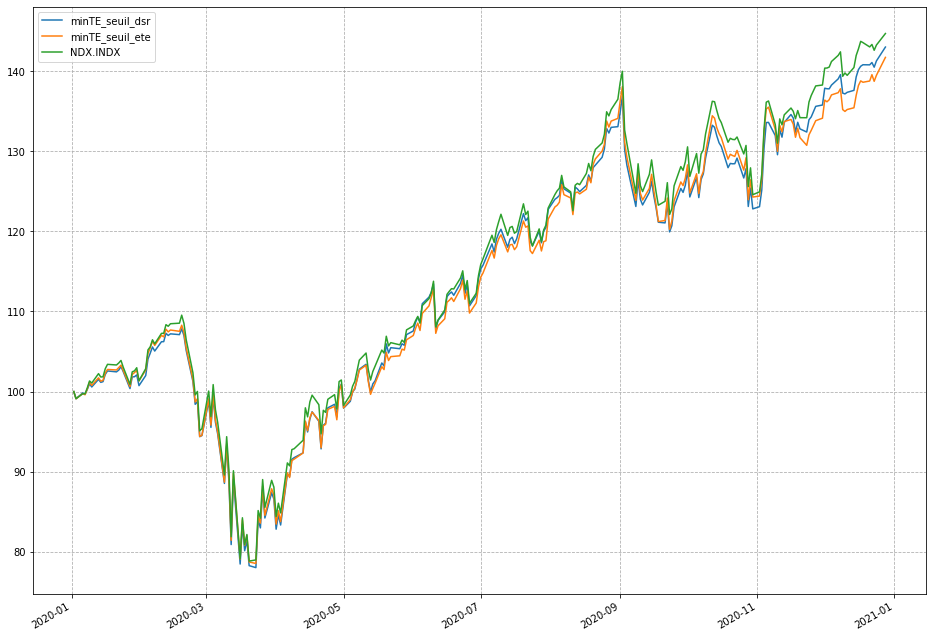

In [47]:
rebased[['minTE_seuil_dsr',"minTE_seuil_ete",'NDX.INDX']].head(250).plot(figsize=(16, 12))
plt.grid(linestyle="--")

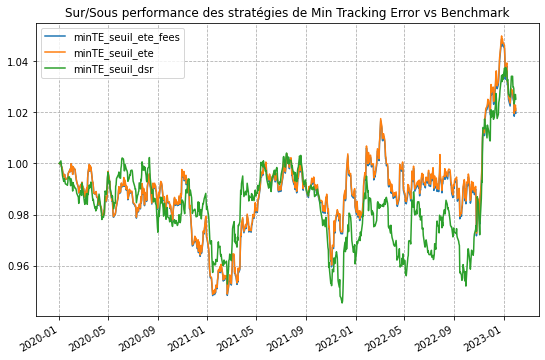

In [49]:
# Graphique de la sur/sous performance des stratégies versus l'indice de référence

(rebased.iloc[0:,:-1].div(rebased["NDX.INDX"], axis=0)).plot(figsize=(9, 6))
plt.title("Sur/Sous performance des stratégies de Min Tracking Error vs Benchmark")
plt.grid(linestyle="--")